In [132]:
from sklearn.datasets import  make_blobs
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.linear_model import RidgeClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import pandas as pd

# Generate synthetic one modal dataset

In [133]:
X, y = make_blobs(n_samples=2502, centers=2, n_features=2, random_state=259202)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=259202)

In [134]:
X_train, y_train

(array([[ 1.74771932,  7.06026374],
        [11.63628313,  2.43832222],
        [ 7.83213125,  3.25616202],
        ...,
        [11.15319987,  2.83310227],
        [ 0.365067  ,  5.57690838],
        [11.17654856,  2.5515603 ]], shape=(2001, 2)),
 array([0, 1, 1, ..., 1, 0, 1], shape=(2001,)))

In [135]:
X_test.shape, y_test.shape

((501, 2), (501,))

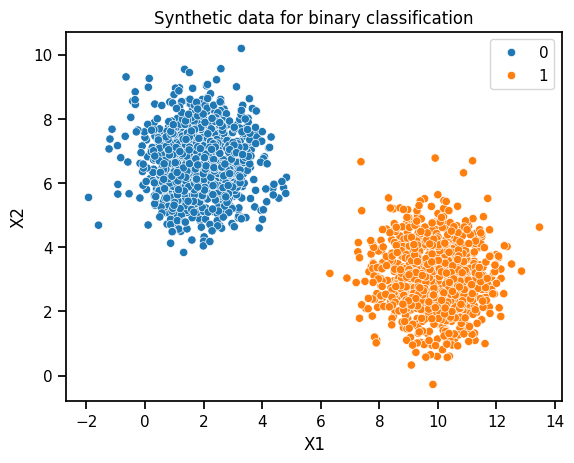

In [136]:
def plot_2d_data(X, y, title):
    sns.set_context("notebook")
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()
plot_2d_data(X_train, y_train, "Synthetic data for binary classification")

Normalize the data

In [137]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

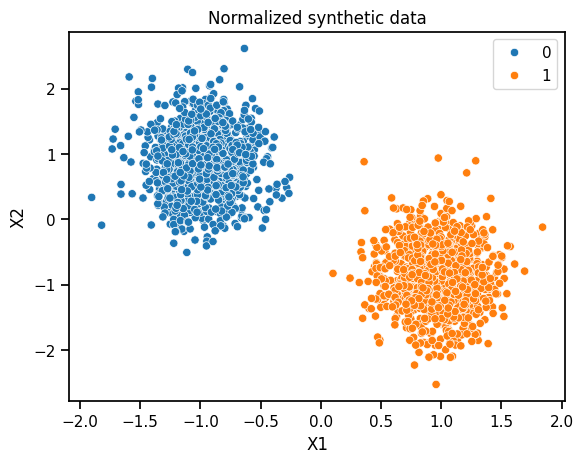

In [138]:
plot_2d_data(X_train, y_train, "Normalized synthetic data")

# Analytical linear classifier with L2 regularization

In [139]:
def analytical_linear_l2(X, y, lambda_):

    X_ = np.c_[np.ones(X.shape[0]), X] # [N, D+1]

    I = np.eye(X_.shape[1]) # [D+1, D+1]
    I_ = I*lambda_
    
    # (D+1, N) @ (N, D+1) = (D+1, D+1)  <- X_.T @ X_
    # (D+1, D+1) @ (D+1, N) = (D+1, N)  <- inv(X_.T @ X_ + I_) @ X_.T
    # (D+1, N) @ (N, 1) = (D+1, 1)      <- X_.T @ y
    w = np.linalg.inv(X_.T @ X_ + I_) @ X_.T @ y
    return w

In [140]:
w = analytical_linear_l2(X_train, y_train, 1)

In [141]:
w.shape, w

((3,), array([ 0.5014985 ,  0.41123909, -0.08663209]))

In [142]:
X_test_ = np.c_[np.ones(X_test.shape[0]), X_test]
X_test_.shape, X_test_

((501, 3),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        ...,
        [ 1.        , -1.12383436,  0.80544164],
        [ 1.        ,  1.14406207, -1.31397891],
        [ 1.        , -0.88148021,  0.72198783]], shape=(501, 3)))

In [143]:
scores = X_test_ @ w
scores.shape, scores[:5] , X_test_[:5]

((501,),
 array([ 0.93118576, -0.19255291,  0.06515473,  1.02054516,  0.21864988]),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        [ 1.        ,  1.18110244, -0.38474391],
        [ 1.        , -0.40260687,  1.35378172]]))

In [144]:
# important to choose the right threshold for scores
y_pred = np.where(scores > 0, 1, 0)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7425


Choose the best lambda

In [145]:
best_w = None
best_l = None
best_acc = 0
for l in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
    w = analytical_linear_l2(X_train, y_train, l)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > 0.5, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Lambda={l}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_w = w
        best_l = l
w = best_w
l = best_l

Lambda=0.01, Accuracy: 1.0000
Lambda=0.05, Accuracy: 1.0000
Lambda=0.1, Accuracy: 1.0000
Lambda=0.5, Accuracy: 1.0000
Lambda=1.0, Accuracy: 1.0000
Lambda=5.0, Accuracy: 1.0000
Lambda=10.0, Accuracy: 1.0000
Lambda=50.0, Accuracy: 1.0000
Lambda=100.0, Accuracy: 1.0000


Choose the best threshold

In [146]:
best_s = None
best_acc = 0
for s in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    w = analytical_linear_l2(X_train, y_train, 1)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > s, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Score thrs={s}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_s = s
        best_acc = accuracy
        
s = best_s
accuracy = best_acc

Score thrs=0.01, Accuracy: 0.7505
Score thrs=0.05, Accuracy: 0.8164
Score thrs=0.1, Accuracy: 0.8882
Score thrs=0.5, Accuracy: 1.0000
Score thrs=1.0, Accuracy: 0.7026
Score thrs=5.0, Accuracy: 0.5070


Make the predictions

In [147]:
scores = X_test_ @ w
y_pred = np.where(scores > 0.5, 1 ,0)

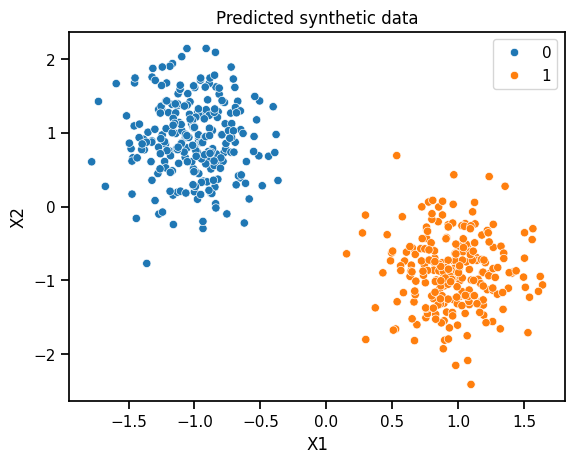

In [148]:
plot_2d_data(X_test, y_pred, "Predicted synthetic data")

In [149]:
def plot_decision_boundary(w, X, y):

    # mesh grid
    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # The height values over which the contour is drawn
    Z = w[0] + w[1] * xx + w[2] * yy
    Z = Z.reshape(xx.shape)
    
    # print("Z:", Z, Z.shape)
    
    plt.figure(figsize=(10, 8))
    
    # decision boundary
    plt.contourf(xx, yy, Z > 0.5, alpha=0.3)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary analytical")
    plt.show()

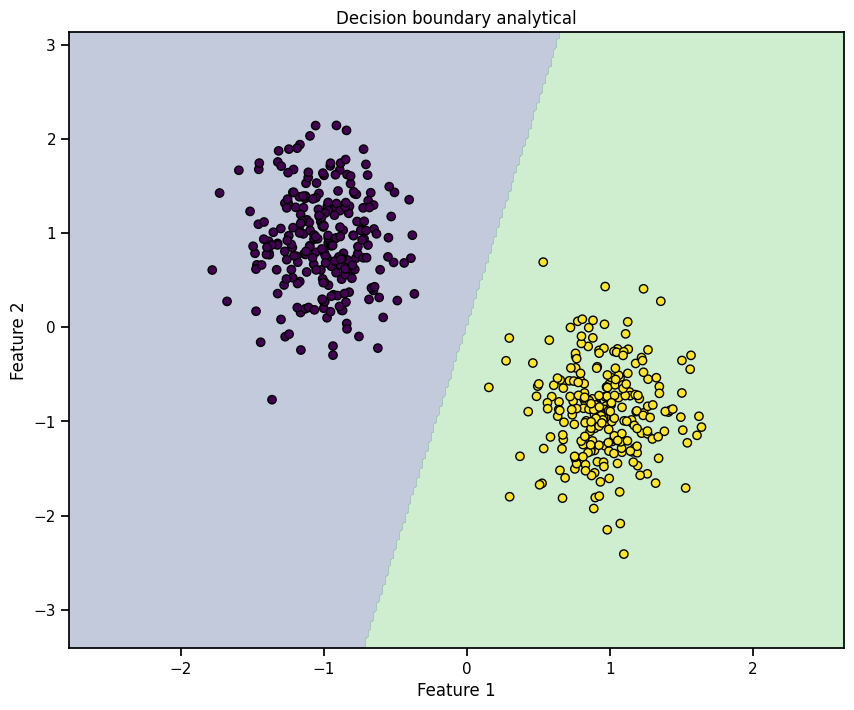

In [150]:
plot_decision_boundary(w, X_test, y_pred)

Confusion matrix analytical

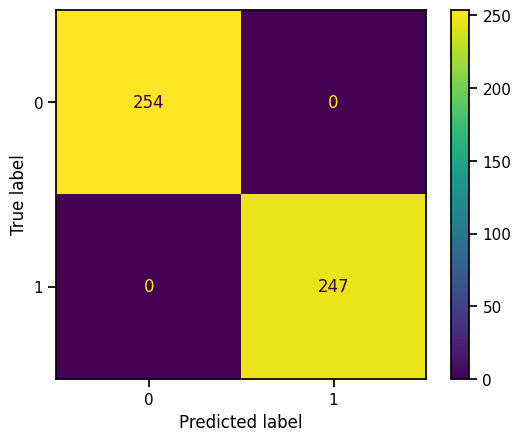

In [151]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [152]:
cr = classification_report(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp) # swoistosc
sensitivity = tp / (tp+fn) # czulosc
print(cr)
print(f"specificity: {specificity}")
print(f"sensitivity: {sensitivity}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

specificity: 1.0
sensitivity: 1.0


In [153]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc_analytical = auc(fpr, tpr)


print(f"fpr: {fpr}")
print(f"tpr: {tpr}") 
print(f"thresholds: {thresholds}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.27891983  0.6204122  -0.33270952]


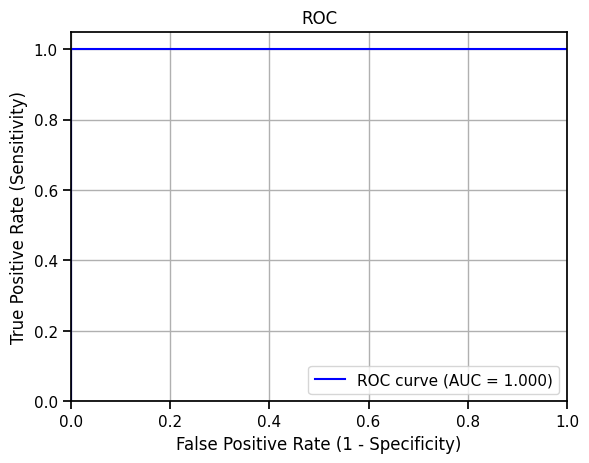

In [154]:
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc(fpr, tpr):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Sklearn Ridge Classifier

In [155]:
# model training
clf = RidgeClassifier(alpha=3.0).fit(X_train, y_train) # alpha controls the regularization strength of the model

In [156]:
y_pred_sklearn = clf.predict(X_test)
scores_sklearn = clf.decision_function(X_test)
y_pred_sklearn[:5], scores_sklearn[:5]

(array([1, 0, 0, 1, 0]),
 array([ 0.86271618, -1.38314579, -0.86770518,  1.03947938, -0.5637464 ]))

In [157]:
accuracy_sklearn = clf.score(X_test, y_test)
print(f"RidgeClassifier accuracy: {accuracy_sklearn:.4f}")

RidgeClassifier accuracy: 1.0000


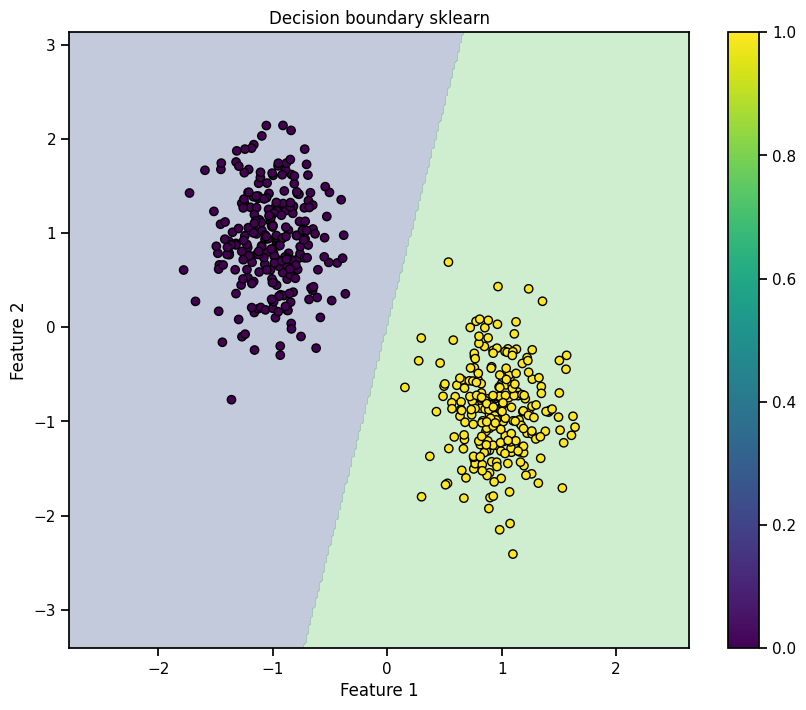

In [158]:
def plot_decision_boundary_ridge(clf, X, y):

    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary sklearn")
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundary_ridge(clf, X_test, y_test)

Confusion matrix sklearn

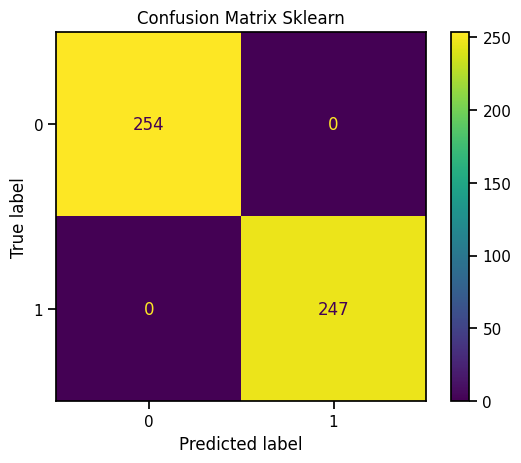

In [159]:
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn)
disp.plot()
plt.title("Confusion Matrix Sklearn")
plt.show()

Classification raport

In [160]:
cr_sklearn = classification_report(y_test, y_pred_sklearn)
tn, fp, fn, tp = cm_sklearn.ravel()
specificity_sklearn = tn / (tn+fp)  # swoistość
sensitivity_sklearn = tp / (tp+fn)  # czułość
print(cr_sklearn)
print(f"Specificity: {specificity_sklearn}")
print(f"Sensitivity: {sensitivity_sklearn}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Specificity: 1.0
Sensitivity: 1.0


ROC Curve

In [161]:
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, scores_sklearn)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

print(f"fpr: {fpr_sklearn}")
print(f"tpr: {tpr_sklearn}") 
print(f"thresholds: {thresholds_sklearn}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.55784358  0.24214004 -1.66342595]


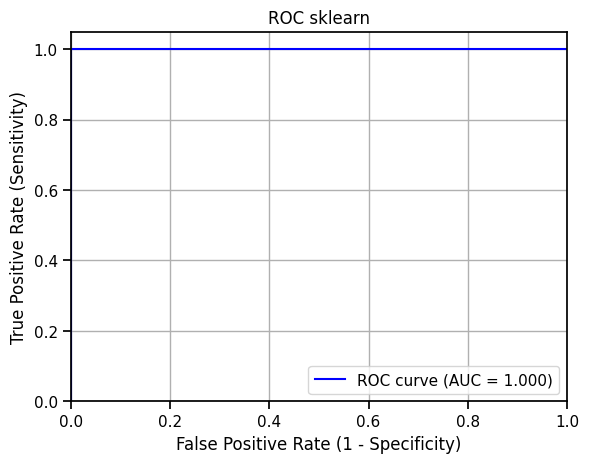

In [162]:
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', label=f'ROC curve (AUC = {auc(fpr_sklearn, tpr_sklearn):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC sklearn')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [163]:
start_time = time.time()
for _ in range(1000):
    w = analytical_linear_l2(X_train, y_train, 1)
analytical_time = time.time() - start_time

start_time = time.time()
for _ in range(1000):
    clf = RidgeClassifier().fit(X_train, y_train)
sklearn_time = time.time() - start_time

print(f"Analytical time: {analytical_time:.6f} s")
print(f"Sklearn time: {sklearn_time:.6f} s")

Analytical time: 0.049406 s
Sklearn time: 1.003208 s


In [164]:
comparison_data = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC', 'Training Time (s)'],
    'Analytical Classifier': [accuracy, sensitivity, specificity, auc_analytical, analytical_time/1000],
    'RidgeClassifier': [accuracy_sklearn, sensitivity_sklearn, specificity_sklearn, auc_sklearn, sklearn_time/1000]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Metric,Analytical Classifier,RidgeClassifier
0,Accuracy,1.000000,1.000000
1,Sensitivity,1.000000,1.000000
2,Specificity,1.000000,1.000000
3,AUC,1.000000,1.000000
4,Training Time (s),0.000049,0.001003
